# Lab 4-4: Atmospheric temperatures and stability
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

In [7]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import altair as alt

## SOS Data

In [8]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

## Stability

Stability is characterized with many different methods. One of the simpler methods is to characterize the "static stability" - the stabiliy of the atmopshere due to stratification alone. This is done by using the gradient in potential temperature, 

$$\frac{d \theta}{dz}$$

Let's calculate the static stability of the atmosphere throughout the entire season. We will use a finite difference approximation to the derivative above using measurements at the snow surface and at 5 meters. We will also ignore the fact that the snow depth is fluctuating.

$$ \frac{d \theta}{d z} = \frac{\Delta \theta}{\Delta z} = \frac{\theta_{5m} - \theta_{surf}}{5}$$

In [9]:
T_vars = [
    'Tsurfpot_c', 'Tpot_5m_c', 
]
stability_df = sos_dataset[
    T_vars
    
].to_dataframe()
stability_df.head()

stability_df['static_stability'] = (stability_df['Tpot_5m_c'] - stability_df['Tsurfpot_c'])/5

<Axes: xlabel='time'>

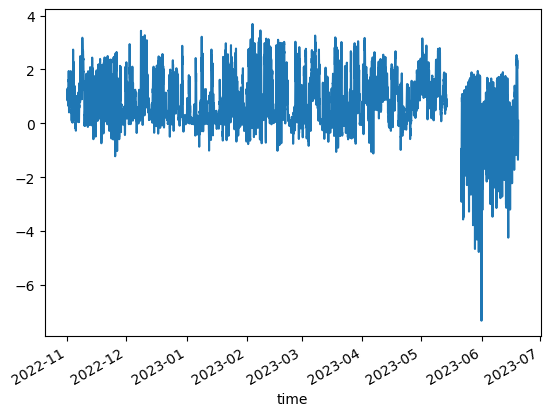

In [10]:
stability_df['static_stability'].plot()

We see that the stability was positive (stable) during the winter and spring, when there was snow. When the snow dissapears, unstable conditions prevail!

## Temperature Profiles

### Extract temperature data

In [11]:
T_vars = [
    'Tsurf_c', 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c'
]
air_temp_df = sos_dataset[
    T_vars
    
].to_dataframe().melt(ignore_index=False)
air_temp_df

variable      value
time                                   
2022-11-01 00:00:00  Tsurf_c  -9.308777
2022-11-01 00:30:00  Tsurf_c  -9.023499
2022-11-01 01:00:00  Tsurf_c  -9.931488
2022-11-01 01:30:00  Tsurf_c  -9.524658
2022-11-01 02:00:00  Tsurf_c  -9.457214
...                      ...        ...
2023-06-19 15:30:00  T_20m_c  18.424438
2023-06-19 16:00:00  T_20m_c  18.387238
2023-06-19 16:30:00  T_20m_c  18.592438
2023-06-19 17:00:00  T_20m_c  18.708826
2023-06-19 17:30:00  T_20m_c  18.713923

[232554 rows x 2 columns]

Assign a height variable based on the variable name

In [12]:
var_to_height = {
    'Tsurf_c' : 0,
    'T_1m_c' : 1,
    'T_2m_c' : 2,
    'T_3m_c' : 3,
    'T_4m_c' : 4,
    'T_5m_c' : 5,
    'T_6m_c' : 6,
    'T_7m_c' : 7,
    'T_8m_c' : 8,
    'T_9m_c' : 9,
    'T_10m_c' : 10,
    'T_11m_c' : 11,
    'T_12m_c' : 12,
    'T_13m_c' : 13,
    'T_14m_c' : 14,
    'T_15m_c' : 15,
    'T_16m_c' : 16,
    'T_17m_c' : 17,
    'T_18m_c' : 18,
    'T_19m_c' : 19,
    'T_20m_c' : 20,
}
air_temp_df['height'] = air_temp_df.variable.apply(var_to_height.get)
air_temp_df

variable      value  height
time                                           
2022-11-01 00:00:00  Tsurf_c  -9.308777       0
2022-11-01 00:30:00  Tsurf_c  -9.023499       0
2022-11-01 01:00:00  Tsurf_c  -9.931488       0
2022-11-01 01:30:00  Tsurf_c  -9.524658       0
2022-11-01 02:00:00  Tsurf_c  -9.457214       0
...                      ...        ...     ...
2023-06-19 15:30:00  T_20m_c  18.424438      20
2023-06-19 16:00:00  T_20m_c  18.387238      20
2023-06-19 16:30:00  T_20m_c  18.592438      20
2023-06-19 17:00:00  T_20m_c  18.708826      20
2023-06-19 17:30:00  T_20m_c  18.713923      20

[232554 rows x 3 columns]

Let's look at temp profiles over a spring day, when no snow cover was at the site. We take 3-hourly averages so we can look at fewer profiles

In [13]:
src = air_temp_df.loc['20230606']
src = src.groupby([pd.Grouper(freq='180min'), 'height'])['value'].mean().reset_index()
src

time  height     value
0   2023-06-06 00:00:00       0 -3.008687
1   2023-06-06 00:00:00       1  2.047014
2   2023-06-06 00:00:00       2  2.389058
3   2023-06-06 00:00:00       3  2.577938
4   2023-06-06 00:00:00       4  2.714737
..                  ...     ...       ...
163 2023-06-06 21:00:00      16  8.828940
164 2023-06-06 21:00:00      17  8.885409
165 2023-06-06 21:00:00      18  8.868728
166 2023-06-06 21:00:00      19  8.874654
167 2023-06-06 21:00:00      20  8.913239

[168 rows x 3 columns]

In [14]:
alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').title('Temperature (C)'),
    alt.Y('height:Q').title('Height (m)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    alt.Order('height') # we need this to make sure the lines are connected in the right order (i.e, connecting points in order of their height)
)

alt.Chart(...)

We see that during the night, temperatures are cooler at the surface (stable conditions) and during the day, temperatures are warmer at the surface (unstable conditions). This is the canonical understanding of the daily near-surface temperature cycle.

Let's look at the same thing on a winter day, when it was sunny, but snow was on the ground.

In [15]:
src = air_temp_df.loc['20230202']
src = src.groupby([pd.Grouper(freq='180min'), 'height'])['value'].mean().reset_index()
alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').title('Temperature (C)'),
    alt.Y('height:Q').title('Height (m)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    alt.Order('height')
)

alt.Chart(...)

What's different about this?

Remember, however, that there is some natural cooling in the atmosphere due to the adiabatic lapse rate, on the order of 0.2˚C / 20 m.

### Extract potential temperature data

Do things look different if instead of T we plotted θ?

In [16]:
T_vars = [
    'Tsurfpot_c', 
    'Tpot_1m_c', 'Tpot_2m_c', 'Tpot_3m_c', 'Tpot_4m_c', 'Tpot_5m_c', 
    'Tpot_6m_c', 'Tpot_7m_c', 'Tpot_8m_c', 'Tpot_9m_c', 'Tpot_10m_c', 
    'Tpot_11m_c', 'Tpot_12m_c', 'Tpot_13m_c', 'Tpot_14m_c', 'Tpot_15m_c', 
    'Tpot_16m_c', 'Tpot_17m_c', 'Tpot_18m_c', 'Tpot_19m_c', 'Tpot_20m_c'
]
air_pottemp_df = sos_dataset[
    T_vars
    
].to_dataframe().melt(ignore_index=False)
var_to_height = {
    'Tsurfpot_c' : 0,
    'Tpot_1m_c' : 1,
    'Tpot_2m_c' : 2,
    'Tpot_3m_c' : 3,
    'Tpot_4m_c' : 4,
    'Tpot_5m_c' : 5,
    'Tpot_6m_c' : 6,
    'Tpot_7m_c' : 7,
    'Tpot_8m_c' : 8,
    'Tpot_9m_c' : 9,
    'Tpot_10m_c' : 10,
    'Tpot_11m_c' : 11,
    'Tpot_12m_c' : 12,
    'Tpot_13m_c' : 13,
    'Tpot_14m_c' : 14,
    'Tpot_15m_c' : 15,
    'Tpot_16m_c' : 16,
    'Tpot_17m_c' : 17,
    'Tpot_18m_c' : 18,
    'Tpot_19m_c' : 19,
    'Tpot_20m_c' : 20,
}
air_pottemp_df['height'] = air_pottemp_df.variable.apply(var_to_height.get)


In [17]:
src = air_pottemp_df.loc['20230202']
src = src.groupby([pd.Grouper(freq='180min'), 'height'])['value'].mean().reset_index()
alt.Chart(
    src
).mark_line().encode(
    alt.X('value:Q').title('Potential temperature (C)'),
    alt.Y('height:Q').title('Height (m)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    alt.Order('height')
)

alt.Chart(...)

It's pretty similar. That's because we aren't looking at temperatures over a very large range of pressures!

### Compare temperature and potential temperatures directly.

Let's overlay some of the profiles above to see if the gradients are indeed similar.

In [26]:
src = air_temp_df.loc['20230202']
src = src.groupby([pd.Grouper(freq='180min'), 'height'])['value'].mean().reset_index()
temp_chart = alt.Chart(
    src[src.time.isin(['2023-02-02 00:00:00', '2023-02-02 12:00:00'])]
).mark_line().encode(
    alt.X('value:Q').title('Temperature (C) (solid lines)'),
    alt.Y('height:Q').title('Height (m)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    alt.Order('height')
)

src = air_pottemp_df.loc['20230202']
src = src.groupby([pd.Grouper(freq='180min'), 'height'])['value'].mean().reset_index()
pottemp_chart = alt.Chart(
    src[src.time.isin(['2023-02-02 00:00:00', '2023-02-02 12:00:00'])]
).mark_line(strokeDash=[3,3]).encode(
    alt.X('value:Q').title('Potential temperature (C) (dashed lines)'),
    alt.Y('height:Q').title('Height (m)'),
    alt.Color('hoursminutes(time):O').scale(scheme='rainbow'),
    alt.Order('height')
)


(temp_chart + pottemp_chart).resolve_scale(x='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_87532/2739847647.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  src[src.time.isin(['2023-02-02 00:00:00', '2023-02-02 12:00:00'])]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_87532/2739847647.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  src[src.time.isin(['2023-02-02 00:00:00', '2023-02-02 12:00:00'])]


alt.LayerChart(...)